In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil
import imageio
import imageio_ffmpeg
import configparser
from PIL import Image
import io
import math
from tqdm import tqdm

root_folder = 'E:/lumen_network-master/'
pattern_file = 'config_embryo_pumping_mod.pat'
config_file = 'example.ini'
img_path=os.path.normpath(os.path.join(root_folder, 'sim_results/img'))
results_folder = os.path.normpath(os.path.join(root_folder, 'sim_results'))

sys.path.append((os.path.normpath(os.path.join(root_folder, 'network'))))
import network as net
    
def createFrame(m, coordinates, area_dynamics, lumen_type, edge_list,initialize=True):
    color_list = ['blue', 'red', 'green', 'orange']
    if initialize:
        plt.figure(figsize=(8, 8))   
    plt.axis('equal')
    plt.axis('off')    
    for i in range(len(coordinates)) :
        plt.scatter(coordinates[i, 0], coordinates[i, 1], s=area_dynamics[m, i+1]*300, color=color_list[lumen_type[i]], zorder=1)
    for k in range(len(edge_list)) :
        plt.plot((coordinates[edge_list[k, 0]][0], coordinates[edge_list[k, 1]][0]), 
                 (coordinates[edge_list[k, 0]][1], coordinates[edge_list[k, 1]][1]), color='k', zorder=0, linewidth=3)
    return(plt)   

def get_img_from_fig(fig):
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='jpg')
    io_buf.seek(0)
    image = Image.open(io_buf)
    data = np.asarray(image)    
    io_buf.close()
    return bytes(data)

# wrapper function for the simulation
def simulate(project_root_folder, pattern_file, simulation_file,simulation_name=""):   
    #delete old simulation files
    os.chdir(os.path.join(project_root_folder, 'outputs'))
    dir_path = os.path.normpath(os.path.join(project_root_folder, 'outputs\\config'))
    try:
        shutil.rmtree(dir_path)
    except:
        pass
    #run initialization of network pattern
    sys.path.append((os.path.join(os.path.dirname(os.getcwd()), 'network')))
    pattern = "../patterns/" + pattern_file
    %run ../network/gen_config.py {pattern}
    
    #run simulation
    os.chdir(dir_path)
    %run ../../network/simulation.py {simulation_file}    
    os.chdir(os.path.join(project_root_folder, 'outputs'))
    
    #the results are copied to folder 'dir_results' a prefix is added to each file to identify which simulation they belong to
    dir_results = os.path.join(os.path.dirname(os.getcwd()), 'sim_results')
    if not os.path.exists(dir_results):
        os.makedirs(dir_results)
    output_files_path=os.path.join(os.getcwd(), 'config\\network')
    files = [f for f in os.listdir(output_files_path) if os.path.isfile(os.path.join(output_files_path, f))]
    for f in files:
        newname=os.path.join(dir_results, simulation_name)  + "_" + f
        shutil.copy(os.path.join(output_files_path, f), newname)        
    output_files_path=os.path.join(os.getcwd(), 'config\\out')
    files = [f for f in os.listdir(output_files_path) if os.path.isfile(os.path.join(output_files_path, f))]
    for f in files:
        newname=os.path.join(dir_results, simulation_name)  + "_" + f
        shutil.copy(os.path.join(output_files_path, f), newname)        
    newname=os.path.join(dir_results, simulation_name)  + "_" + pattern_file
    shutil.copy(pattern, newname)
    newname=os.path.join(dir_results, simulation_name)  + "_" + simulation_file
    shutil.copy(simulation_file, newname)
       
# wrapper function to update both config files with parameters at the same time
def update_config(project_root_folder, pattern_file, config_file, **kwargs):
    #updates all the passed parameters in the corresponding configuration files
    pattern_path = os.path.normpath(os.path.join(os.path.join(project_root_folder,'patterns'),pattern_file))
    simconf_path = os.path.normpath(os.path.join(os.path.join(project_root_folder,'outputs'),config_file))
    configPat = configparser.ConfigParser()
    configPat.read(pattern_path)
    configSim = configparser.ConfigParser()
    configSim.read(simconf_path)
    kwargs["tpl"] = config_file
    for key, value in kwargs.items():
        for section in configPat.sections():
            if configPat.has_option(section, key):
                configPat[section][key] = str(value)
        for section in configSim.sections():
            if configSim.has_option(section, key):
                configSim[section][key] = str(value)
        with open(pattern_path, 'w') as configfile:    # save
            configPat.write(configfile)
        with open(simconf_path, 'w') as configfile:    # save
            configSim.write(configfile)
            
# wrapper to plot results
def plot_results(results_folder, sim_prefix, save_path='', show=True, size=(32,8), title_pump="Lumen pumping rate", title_area="Lumen area evolution", percentage_t_pumping=100,logaritmic_pump=True):
    # all files must be placed in the same folder
    #percentage_t: allows to trim the x axis, given that simulation can reach a steady state early
    # pumping rate plot    
    pumping_rates = np.loadtxt(os.path.normpath(os.path.join(results_folder, sim_prefix + '_pumping.dat')))
    plt.figure(figsize=size)
    plt.subplot(1, 4, 1)
    if logaritmic_pump:
        plt.xscale('log')
    max_t = math.floor(percentage_t_pumping/100*len(pumping_rates))
    print(max_t)
    for i in range(len(pumping_rates[0])-1) :
        plt.plot(pumping_rates[range(0,max_t), 0], pumping_rates[range(0,max_t), i+1])
    plt.xlabel('Time [a.u.]', fontsize=15)
    plt.ylabel('Pumping rate [a.u.]', fontsize=15)
    plt.title(title_pump, size=15, ha="center")
    
    # lumen areas plot
    area_dynamics = np.loadtxt(os.path.normpath(os.path.join(results_folder, sim_prefix + '_area.dat')))
    plt.subplot(1, 4, 2)
    plt.xscale('log')
    for i in range(len(area_dynamics[0])-1) :
        plt.plot(area_dynamics[:, 0], area_dynamics[:, i+1])
    plt.xlabel('Time [a.u.]', fontsize=15)
    plt.ylabel('Area [a.u.]', fontsize=15)
    plt.title(title_area, size=15, ha="center")
    
    # file loading for image plot
    areas = np.loadtxt(os.path.join(results_folder, sim_prefix + '_lumen.dat'), usecols=3)
    lumen_type = np.loadtxt(os.path.join(results_folder, sim_prefix + '_lumen.dat'), usecols=4, dtype=int)
    coordinates = np.loadtxt(os.path.join(results_folder, sim_prefix + '_lumen_coord.dat'))
    edge_list = np.loadtxt(os.path.join(results_folder, sim_prefix + '_lumen_lumen.dat'), usecols=(0, 1), dtype=int)
    color_list = ['blue', 'red', 'green', 'orange']

    plt.subplot(1, 4, 3)
    m = 0
    createFrame(m, coordinates, area_dynamics, lumen_type, edge_list,initialize=False)
    plt.title("Initial state", size=25, ha="center")

    plt.subplot(1, 4, 4)
    m = len(area_dynamics)-1
    createFrame(m, coordinates, area_dynamics, lumen_type, edge_list,initialize=False)
    plt.title("Final state", size=25, ha="center")
    plt.tight_layout()
    if save_path!='':
        try :
            os.mkdir(save_path)
        except :
            pass
        plt.savefig(os.path.normpath(os.path.join(save_path, sim_prefix + '_results.jpg')), transparent=False)

    if show:
        plt.show()
        
# read parameters and results of a finished simulation
def fetch_sim_final_data(results_folder, sim_prefix, pat_file, simu_file):
    #updates all the passed parameters in the corresponding configuration files
    pattern_path = os.path.join(results_folder, sim_prefix + "_" + pat_file)
    simconf_path = os.path.join(results_folder, sim_prefix + "_" + simu_file)
    fstate_path = os.path.join(results_folder, sim_prefix + "_" + "area.log")
    configPat = configparser.ConfigParser()
    configPat.read(pattern_path)
    configSim = configparser.ConfigParser()
    configSim.read(simconf_path)
    configEnd = configparser.ConfigParser()
    configEnd.read(fstate_path)
    parameters = dict()
    patparams={"seed":"network", "gamma_border" : "tensions", "gamma_c_border" : "tensions",
               "vol_avg" : "volume", "vol_std" : "volume", "modified_pumping" : "pumping", 
               "lambda_max_avg" : "pumping", "lambda_max_std" : "pumping", 
               "lambda_max_border_avg" : "pumping", "lambda_max_border_std" : "pumping",
               "phi_avg" : "pumping", "phi_std" : "pumping", 
               "phi_border_avg" : "pumping", "phi_border_std" : "pumping"}    
    for key, value in patparams.items():
        try:
            parameters[key] = configPat[value][key]
        except:
            pass
    confparams={"pumping_type" : "pumping", "omega" : "pumping", "damping" : "pumping", 
                "period" : "pumping"}    
    for key, value in confparams.items():
        try:
            parameters[key] = configSim[value][key]
        except:
            pass 
    endresults={"total" : "volume", "final" : "volume", "id" : "lumen", 
                "end" : "time"}   
    for key, value in endresults.items():
        try:
            parameters[key] = configEnd[value][key]
        except:
            pass      
    return parameters


def paramsPumpingOnly(dictParams):
    auxpar=("pumping_type", "lambda_max_avg", "lambda_max_std","lambda_max_border_avg","lambda_max_border_std",
            "phi_avg", "phi_std", "phi_border_avg", "phi_border_std", "omega", "damping", "period")
   
    auxdic = dict()
    for k in auxpar:
        try:
            auxdic[k] = float(dictParams[k])
        except:
            auxdic[k] = dictParams[k]
    
    conv="{}: $\lambda_{{max}}(\mu_{{pi}}=${:.3f},$\sigma_{{pi}}=${:.3f}); $\lambda_{{max-border}}(\mu_{{b}}=${:.3f},$\sigma_{{b}}=${:.3f});\
    \n $\phi(\mu_{{fi}}=${:.3f};$\sigma_{{fi}}=${:.3f});  $\phi_{{border}}(\mu_{{fb}}=${};$\sigma_{{fb}}=${:.3f}); $\omega=${:.3f}; \
    $\kappa=${}; $\\tau=${:.3f}".format(*auxdic.values())
    return conv

def paramsAreaOnly(dictParams):
    auxpar=("gamma_border", "gamma_c_border", "vol_avg","vol_std")
    auxdic = dict()
    for k in auxpar:
        try:
            auxdic[k] = float(dictParams[k])
        except:
            auxdic[k] = dictParams[k]
    conv="$\gamma=$1.0; $\gamma_{{border}}=${}; $\gamma_{{contact}}=$1.0; $\gamma_{{c-border}}=${};\
    \n$a_{{0}}(\mu_{{area}}={:.3f},\sigma_{{area}}={:.3f}$)".format(*auxdic.values())
    return conv

# write results table of a run
def generate_run_results_table(results_folder, run_name, pattern_file, config_file, subfolder="result_tables"):
    table_folder=os.path.join(results_folder, subfolder)
    try :
        os.mkdir(table_folder)
    except :
        pass
    os.chmod(results_folder, 504)
    filepath = os.path.join(table_folder, run_name + '_results_table.dat')
    start = True
    n=1
    #get all the files with the prefix     
    for filename in os.listdir(results_folder):
        if filename.startswith(run_name) and filename.endswith('area.dat'):
            sname = filename.partition("_area.dat")[0]
            #fetch the results
            dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)
            if start:
                header = "Nr\t" + '\t'.join(map(str, dicc.keys()))        
                fresults = open(filepath, 'w')
                fresults.write(header)
                fresults.write("\n")
                fresults.close()
                start = False
            fresults = open(filepath, 'a')
            fresults.write(str(n) +'\t' + '\t'.join(map(str, dicc.values()))) 
            fresults.write("\n")
            fresults.close()
            n += 1

#explore parameters specifying a range for each one.
def explore_parameter(project_root_folder, results_folder, img_path, pattern_file, simulation_file, dic, run_name="",sim_int_number=0):
    import itertools
    import datetime
    
    keys = dic.keys()
    values = (dic[key] for key in keys)
    combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    print(str(datetime.datetime.now()))
    print("About to start the simulation of " + str(len(combinations)) + " combinations \nwith parameters "+ str(list(dic.keys())))
    for combination in combinations:
        print(str(combination))
        update_config(project_root_folder, pattern_file, simulation_file,**combination)
        try:
            print(str(datetime.datetime.now()))
            print(str("Run {} - Simulation number: {:010d}").format(run_name,sim_int_number))
            sim_name = run_name + "_" + "sim" + '{:010d}'.format(sim_int_number)
            simulate(project_root_folder, pattern_file, 
                simulation_file, simulation_name=sim_name)

            dicc = fetch_sim_final_data(results_folder, sim_name, pattern_file, config_file)

            plot_results(results_folder, sim_prefix=sim_name, save_path=img_path, show=True, size=(32,8), 
                         title_pump=paramsPumpingOnly(dicc), 
                         title_area=paramsAreaOnly(dicc))
        except Exception:
            print(Exception)
        sim_int_number = sim_int_number + 1 
    print("Exploration ended: "+ str(datetime.datetime.now()))
    generate_run_results_table(results_folder, run_name, pattern_file, config_file)
    
#wrapper movie
def make_movie(results_folder, img_path, sim_file_prefix, video_name="", slow_frames=2, frame_step=50, extra_frames_end=10,resol=(576, 576), duration=10):
    #slow_frames=2 deactivates making the ending slower
    #extra_frames_end adds extra frames repeating the last one so that the final state persists longer
    
    try :
        os.mkdir(img_path)
    except :
        pass
    os.chmod(img_path, 504)
    where=os.path.join(results_folder,sim_file_prefix+"_")
    areas = np.loadtxt(where + 'lumen.dat', usecols=3)
    lumen_type = np.loadtxt(where + 'lumen.dat', usecols=4, dtype=int)
    coordinates = np.loadtxt(where + 'lumen_coord.dat')
    edge_list = np.loadtxt(where + 'lumen_lumen.dat', usecols=(0, 1), dtype=int)
    area_dynamics = np.loadtxt(where + 'area.dat')
    color_list = ['blue', 'red', 'green', 'orange']
    arr1 = np.array(list(range(0,len(area_dynamics)-slow_frames+1,frame_step)))
    arr2 = np.array(list(range(len(area_dynamics)-slow_frames+1,len(area_dynamics),1)))
    arr3 = np.full(extra_frames_end,len(area_dynamics)-1)
    arr = np.concatenate((arr1, arr2, arr3))
    
    frames_per_second=math.floor(len(arr)/duration)
    if video_name=="":
        video_name=sim_file_prefix+".mp4"
        print("Creating video "+ video_name + "...")
    writer = imageio_ffmpeg.write_frames(str(img_path + "\\" + video_name), resol, 
                                        pix_fmt_in="rgb24", fps=frames_per_second)  # size is (width, height)
    writer.send(None)  # seed the generator    
    for m in tqdm(arr) :
        img =  createFrame(m, coordinates, area_dynamics, lumen_type, edge_list,initialize=True)        
        writer.send(get_img_from_fig(img)) 
        img.close()        
    writer.close()


# Original model

## Pumping with constant rate, same $\lambda$ value for all the network

Pattern file found
Simulation running...
Simulation ended
8216


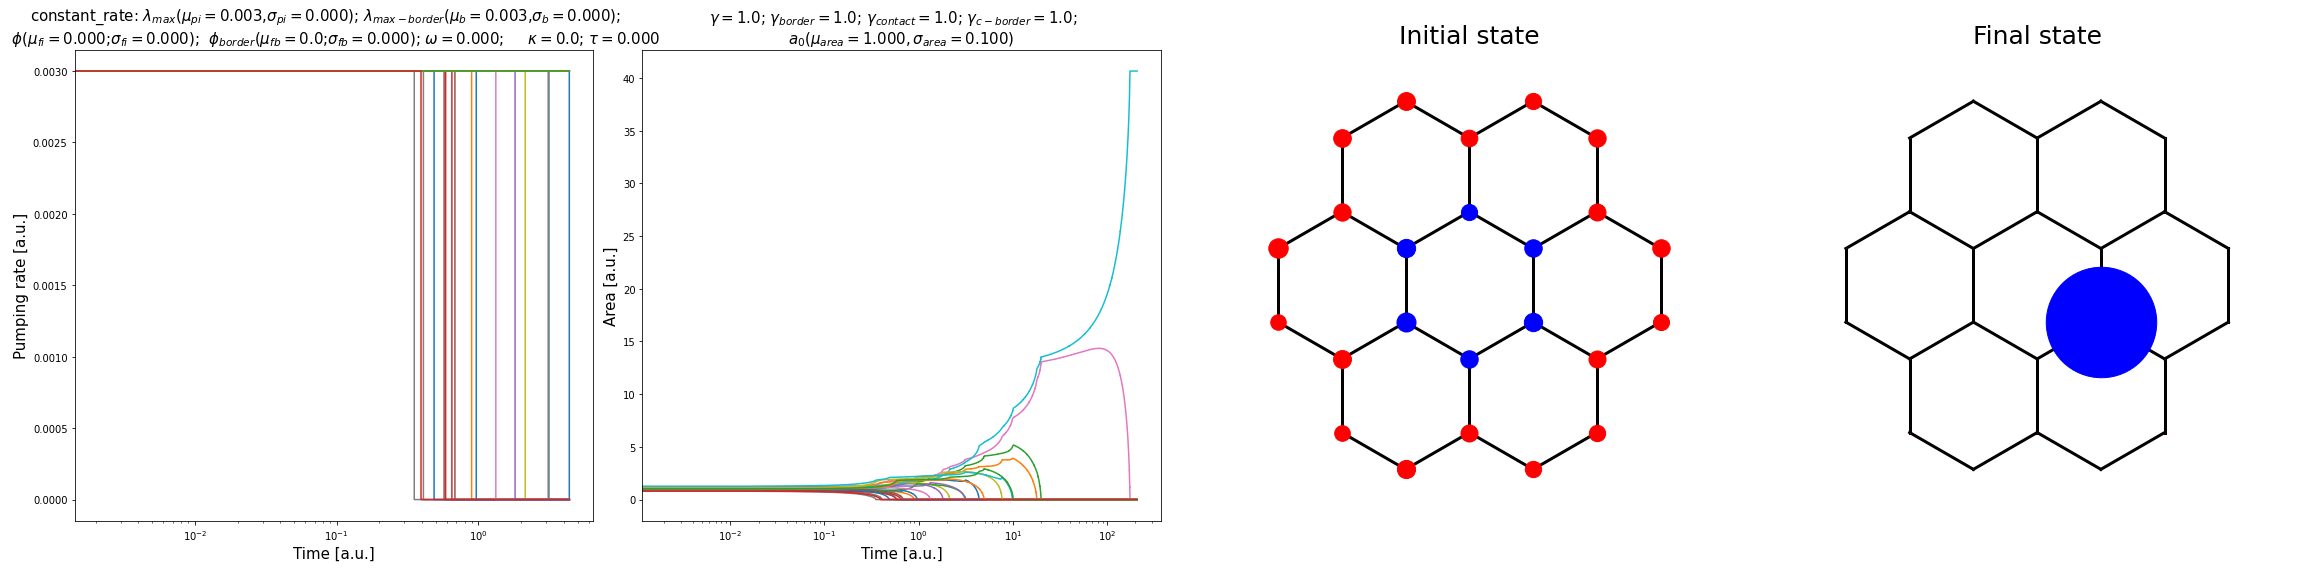

In [3]:

sname = "constant_rate_unique_lambda"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              lambda_max_avg=0.003, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.003, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 

simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc),percentage_t_pumping=50)
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "constant_rate_unique_lambda", frame_step=50,duration=7) 

## Pumping with constant rate, same $\lambda$ value for all the network: higher value

In [ ]:
sname = "constant_rate_unique_high_lambda"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              lambda_max_avg=0.007, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.007, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 

simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc),percentage_t_pumping=50)
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "constant_rate_unique_high_lambda", frame_step=50,duration=7) 

# Novelty: different $\lambda$ pumping rates according to cell interface type

## 1) Batch simulation: unique constant $\lambda$ for all ICM-ICM lumens. TE-ICM pumping off. Exploration of $\lambda$ values in range [0.01, 0.08]

In [ ]:
#Parameters:
#[network]
#topology = hexagonal
#nlayers = 2
#pbc = False
#nbicellular = 0
#seed = None

#[tensions]
#gamma_border = 0.90
#gamma_c_border = 1.00

#[volume]
#vol_avg = 1
#vol_std = 0.1

# New parameters: PUMPING
#[Pumping]
#modified_pumping = True
#lambda_max_avg = 0.006
#lambda_max_std = 0
#lambda_max_border_avg = 0.006
#lambda_max_border_std = 0
#phi_avg = -8
#phi_std = 4
#phi_border_avg = -5
#phi_border_std = 4
#pumping_type = x_exp
#omega = 3
#damping = 0
#period = 20
#save_pumping = True



nombre_run = "constant_rate_unique_lambda_ICM_batch"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              gamma_c_border=1.,
              gamma_border = 0.90,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              lambda_max_avg=0.001, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.000, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 

parameter_run={"lambda_max_avg" : np.arange(0.01,0.09,0.02)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)

In [ ]:
make_movie(results_folder, img_path, "constant_rate_unique_lambda_ICM_batch_sim0000000003", frame_step=50,duration=7) 

## 2) Batch simulation: constant rate of pumping  in ICM-ICM lumens. Different $\lambda$ normally distributed among lumens. No pumping at TE-ICM.


In [ ]:
nombre_run = "constant_rate_normal_lambda_ICM"

update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              lambda_max_avg=0.001, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.000, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


parameter_run={"lambda_max_avg" : np.arange(0.01,0.09,0.02),
               "lambda_max_std" : np.arange(0.01,0.05,0.01)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)

In [ ]:
make_movie(results_folder, img_path, "constant_rate_normal_lambda_ICM_sim0000000000", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "constant_rate_normal_lambda_ICM_sim0000000001", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "constant_rate_normal_lambda_ICM_sim0000000013", frame_step=50,duration=5) 

## 3) Batch simulation: constant rate of pumping  in TE-ICM lumens. Different $\lambda$ normally distributed among lumens. No pumping at ICM-ICM.


In [ ]:
nombre_run = c

update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              lambda_max_avg=0.000, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.000, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


parameter_run={"lambda_max_border_avg" : np.arange(0.001,0.009,0.002),
               "lambda_max_border_std" : np.arange(0.001,0.005,0.001)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)

In [ ]:
make_movie(results_folder, img_path, "constant_rate_normal_lambda_TE_sim0000000000", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "constant_rate_normal_lambda_TE_sim0000000001", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "constant_rate_normal_lambda_TE_sim0000000003", frame_step=50,duration=5)
make_movie(results_folder, img_path, "constant_rate_normal_lambda_TE_sim0000000004", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "constant_rate_normal_lambda_TE_sim0000000006", frame_step=50,duration=5) 

## 4) Sine wave functions

In [ ]:

sname = "sine_wave_function"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'pump_sin',
              vol_std = 0.1,
              lambda_max_avg=0.0, lambda_max_std = 0,
              lambda_max_border_avg = 0.5, lambda_max_border_std = 0.1,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 1.7,
              omega = 10,damping = 2, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "sine_wave_function", frame_step=50,duration=5) 

In [ ]:
nombre_run="sine_wave_functions_batch"                               
   
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              lambda_max_avg=0.000, lambda_max_std = 0,
              lambda_max_border_avg = 0, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 4,damping = 0.3, period = 0, save_pumping = True) 

parameter_run={"pumping_type":["sin_pump", "pump_sin_pos", "pump_sin_abs"],
               "lambda_max_border_avg" : (0.07, 0.5, 0.7), 
               "lambda_max_border_std" : (0.0,0.1),
               "phi_border_std" : (0.0,1.7),
               "damping" : np.arange(0.3,1.1,0.2)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)

In [ ]:
nombre_run="sine_wave_pos"                               
   
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              lambda_max_avg=0.000, lambda_max_std = 0,
              lambda_max_border_avg = 0, lambda_max_border_std = 0,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 4,damping = 0.3, period = 0, save_pumping = True) 

parameter_run={"pumping_type":["pump_sin"],
               "lambda_max_border_avg" : (0.07, 0.5, 0.7), 
               "lambda_max_border_std" : (0.0,0.1),
               "phi_border_std" : (0.0,1.7),
               "damping" : np.arange(0.3,1.1,0.2)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)

In [ ]:
make_movie(results_folder, img_path, "sine_wave_pos_sim0000000008", frame_step=50,duration=5) 
make_movie(results_folder, img_path, "sine_wave_pos_sim0000000030", frame_step=50,duration=5) 

In [ ]:
sname = "sine_wave_pos_function"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'pump_sin_pos',
              gamma_border=1.0,
              vol_std = 0.1,
              lambda_max_avg=0.0, lambda_max_std = 0,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.1,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 4,damping = 0.3, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "sine_wave_pos_function", frame_step=50,duration=5) 

In [ ]:
sname = "sine_wave_pos_function"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'pump_sin_pos',
              gamma_border=1.0,
              vol_std = 0.1,
              lambda_max_avg=0.0, lambda_max_std = 0,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.1,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0,
              omega = 4,damping = 0.3, period = 0, save_pumping = True) 


parameter_run={"lambda_max_border_avg" : (0.003,0.007),
               "phi_border_std" : (0,1,1.7),
               }
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)




## 5) Exponential pumping

In [ ]:
sname = "x_exp"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.000, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.001, lambda_max_border_std = 0.1,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = -0.5, phi_border_std = 0.5,
              omega = 10,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
sname = "x_exp_2"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.000, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.7, lambda_max_border_std = 0.2,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = -0.5, phi_border_std = 0.0,
              omega = 10,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
sname = "no_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.000, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.0, lambda_max_border_std = 0.0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_constant_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.003, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.003, lambda_max_border_std = 0.0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.0,
              omega =0,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_constant_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_constant_high_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.007, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.007, lambda_max_border_std = 0.0,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg =0, phi_border_std = 0.0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_constant_high_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_different_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.003, lambda_max_std = 0.001,
              lambda_max_border_avg = 0.007, lambda_max_border_std = 0.001,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_different_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_different_higher_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'constant_rate',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.03, lambda_max_std = 0.001,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.001,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.0,
              omega = 0,damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_different_higher_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_x_exp_pumping"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.00, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.001,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.05,
              omega = 3, damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_x_exp_pumping", frame_step=50,duration=5)

In [ ]:
sname = "no_tension_x_exp_pumping_2"
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              vol_std = 0.1,
              gamma_border = 1.0,
              lambda_max_avg=0.00, lambda_max_std = 0.000,
              lambda_max_border_avg = 0.7, lambda_max_border_std = 0.01,
              phi_avg = 0, phi_std = 0.0,
              phi_border_avg = 0, phi_border_std = 0.5,
              omega = 3, damping = 0, period = 0, save_pumping = True) 


simulate(project_root_folder=root_folder, pattern_file=pattern_file, 
         simulation_file=config_file, simulation_name=sname)

dicc = fetch_sim_final_data(results_folder, sname, pattern_file, config_file)

try:
    plot_results(results_folder, sim_prefix=sname, save_path=img_path, show=True, size=(32,8), 
                 title_pump=paramsPumpingOnly(dicc), 
                 title_area=paramsAreaOnly(dicc))
except:
    pass

In [ ]:
make_movie(results_folder, img_path, "no_tension_x_exp_pumping_2", frame_step=50,duration=5)

In [ ]:
nombre_run="lambda_border_phi_border_random"  
#fixed gamma=1, fixed omega=3, period=0, pumping center off.
   
update_config(root_folder, pattern_file, config_file,
              seed = "None",
              modified_pumping=True,
              pumping_type = 'x_exp',
              gamma_border=1.0,
              lambda_max_avg=0.000, lambda_max_std = 0,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.01,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0.05,
              omega = 3,damping = 0, period = 0, save_pumping = True) 

parameter_run={"seed" : np.full(20,"None"),
               "lambda_max_border_avg" : (0.07,0.7),
               "phi_border_avg" : (-0.5, -0.2, 0.0, 0.2, 0.5)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)





In [ ]:
nombre_run="no_pumping_no_tension_random"  
#fixed gamma=1, fixed omega=3, period=0, pumping center off.
   
update_config(root_folder, pattern_file, config_file,
              seed = "None",
              modified_pumping=True,
              pumping_type = 'x_exp',
              gamma_border=1.0,
              lambda_max_avg=0.000, lambda_max_std = 0,
              lambda_max_border_avg = 0.00, lambda_max_border_std = 0.00,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0.00,
              omega = 3,damping = 0, period = 0, save_pumping = True) 

parameter_run={"seed" : np.full(50,"None")}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)





In [ ]:
#testing different omegas with periodic pulses. Additional pulses make the simulation diverge

nombre_run="x_exp_omega"                               
   
update_config(root_folder, pattern_file, config_file,
              seed = 123,
              modified_pumping=True,
              pumping_type = 'x_exp',
              gamma_border=0.9,
              lambda_max_avg=0.000, lambda_max_std = 0,
              lambda_max_border_avg = 0.07, lambda_max_border_std = 0.01,
              phi_avg = 0, phi_std = 0,
              phi_border_avg = 0, phi_border_std = 0.05,
              omega = 10, damping = 0, period = 3, save_pumping = True) 

parameter_run={"omega" : (0.3,0.5,0.7,1,2,3)}
        
explore_parameter(project_root_folder=root_folder, results_folder=results_folder,
                  img_path=img_path, pattern_file=pattern_file, 
                  simulation_file=config_file,dic=parameter_run, run_name=nombre_run)